<a href="https://colab.research.google.com/github/vijaytamilselvan/neural-net-from-scratch/blob/main/trigram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
from google.colab import files
uploaded = files.upload()
words = open('names.txt', 'r').read().splitlines()
words[:8]

Saving names.txt to names.txt


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [6]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


(array([  6.,   3.,   4.,  10.,  15.,  17.,  29.,  28.,  43.,  53.,  53.,
         62., 108., 139., 159., 191., 200., 226., 251., 249., 299., 291.,
        291., 315., 336., 342., 330., 254., 265., 311., 238., 223., 191.,
        151., 170., 122., 106.,  89.,  64.,  42.,  35.,  31.,  26.,   8.,
         10.,   7.,   5.,   0.,   1.,   1.]),
 array([-3.1161902 , -2.98841553, -2.86064086, -2.73286619, -2.60509152,
        -2.47731686, -2.34954219, -2.22176752, -2.09399285, -1.96621819,
        -1.83844352, -1.71066885, -1.58289418, -1.45511951, -1.32734485,
        -1.19957018, -1.07179551, -0.94402084, -0.81624618, -0.68847151,
        -0.56069684, -0.43292217, -0.3051475 , -0.17737284, -0.04959817,
         0.0781765 ,  0.20595117,  0.33372583,  0.4615005 ,  0.58927517,
         0.71704984,  0.8448245 ,  0.97259917,  1.10037384,  1.22814851,
         1.35592318,  1.48369784,  1.61147251,  1.73924718,  1.86702185,
         1.99479651,  2.12257118,  2.25034585,  2.37812052,  2.50589519,
 

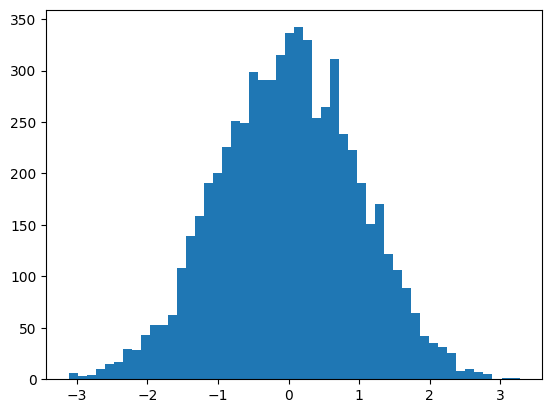

In [ ]:
plt.hist(hpreact.view(-1).tolist(),50)

In [11]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0504956245422363
val 2.097503423690796


The loss I get at the first iteration is very high which indicates that the model predicts the character with the high confidence for wrong character.

In [ ]:
logits[0]

tensor([ 2.7603,  2.7644, -1.9144,  1.0708,  1.2832,  0.1873, -2.3983, -1.7475,
        -2.0877,  1.3505, -0.5690,  1.0778,  2.4107, -0.3958,  2.8949,  0.1269,
        -2.9696, -2.4876, -0.1820,  1.7994,  1.2614, -1.1135, -0.1903, -2.1658,
        -1.7531, -0.4496,  0.6425], grad_fn=<SelectBackward0>)

In [ ]:
#tanh is the activation function introduced to have the non-linearity into the model. When we take the gradient of the tanh which is (1-t*2) * out.grad, t results in zero for most of the cases, which will pass the out.grad to pass through without any learnings.
#Softmax converts the raw logits into the probabilities. We can use cross entropy method to do the softmax and then finding the negative log likelyhood to get the loss of the model.
#Softmax+nll=cross_entropy method. Averaging the 32 input context over 27 classes- Each class do have one probability score that mae be high or low. Finding the negative loglikelyhood for each 32 inputs and then calculating the average.
#tanh has the problem of vanishing gradients when the h value is too high or low, that cause the neuron inefficient to learn the patterns as there is grad of tanh becomes one which pass thr grad without making any change.

#Need of Gaussian distribution-

#Since we neglect the negative values in the probability distribution(tanh neglects neg values), that will eventually become inefficient as these only passes through the postive values and clamps the negative values.
#In order to compensate the above effect of non-linearity, gaussian ditribution is introduced where weights(w) is divided by sq.rt of 10.
#Gaussian distribution makes the zero mean which helps our gradient to be well behaved and preventing symmetry, preventing vanishing/exploding gradient.
#This comes in as spacialized initization names as Kaiming_normal, where the weights will be initialized
#This is less effecting as it doesn't really reduce much of the loss.

#Batch Normalization

#I take the input sample. ex. 32, and normalize this commplete batch (x-x.mean)/x.std
#bngain* batch_norm_output+bnbias
#Batch normalization helps to control the scale of activations which again is connected to well behaved gradient, preventing vanishing and exploding gradient.
#Batch norm has it's own bias and offset we are adding. So, bias at the initialization is not needed when we go for batch norm.
#In addition, bnmean and bnbias is been keeping track without involved in back prop as we make inference using this.


#Batch- norm helps stabilize the model which is very deep(contains lot of layers)
#Activation distribution, gradient distribution, Weight-grad, update to data ratio- Diagnostic tool



In [7]:
@torch.no_grad()
def evaluate_split(split):
    # Choose the appropriate dataset
    splitX, splitY = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[splitX]                          # Look up embeddings
    embcat = emb.view(emb.shape[0], -1)     # Flatten
    hpreact = embcat @ W1                   # Linear layer
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias  # BatchNorm
    h = torch.tanh(hpreact)                 # Non-linear activation
    logits = h @ W2 + b2                    # Output layer

    loss = F.cross_entropy(logits, splitY)  # Calculate loss
    pred = torch.argmax(logits, dim=1)
    acc = (pred == splitY).float().mean()   # Accuracy

    print(f"{split.upper()} → Loss: {loss.item():.4f}, Accuracy: {acc.item()*100:.2f}%")
    return loss.item(), acc.item()


In [9]:
evaluate_split('val')

VAL → Loss: 2.1051, Accuracy: 33.60%


(2.1050572395324707, 0.33599647879600525)

In [10]:
def predict_next_char(context):
    context_idx = [stoi[c] for c in context]   # stoi: character to index
    x = torch.tensor([context_idx])            # batch of 1
    emb = C[x]                                 # embed
    embcat = emb.view(1, -1)                   # flatten
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)           # convert logits to probabilities
    ix = torch.multinomial(probs, num_samples=1).item()  # sample next char index
    return itos[ix]                            # return actual character


In [20]:
predict_next_char('stu')

'e'

In [21]:
def generate_name(max_len=20):
    out = []
    context = [0] * block_size  # start with all start tokens (0)

    while True:
        x = torch.tensor([context])            # batch size = 1
        emb = C[x]
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()

        if ix == 0 or len(out) >= max_len:     # end token or max length
            break
        out.append(itos[ix])                   # convert to char
        context = context[1:] + [ix]           # slide the window

    return ''.join(out)


In [35]:
generate_name()

'kenna'